In [2]:
import pandas as pd
from datetime import datetime
import pm4py
import numpy as np
from collections import defaultdict
from Levenshtein import distance

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

import copy

In [3]:
log = pm4py.read.read_xes("BPIChallenge2017.xes")

C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:35<00:00, 331.20it/s]


In [4]:
log.nunique()

Action                         5
org:resource                 149
concept:name                  26
EventOrigin                    3
EventID                  1202267
lifecycle:transition           7
time:timestamp           1202209
case:LoanGoal                 14
case:ApplicationType           2
case:concept:name          31509
case:RequestedAmount         701
FirstWithdrawalAmount       5930
NumberOfTerms                147
Accepted                       2
MonthlyCost                 5816
Selected                       2
CreditScore                  520
OfferedAmount                663
OfferID                    42995
dtype: int64

In [5]:
log

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144


In [6]:
#Make selection of relevant columns
log_select = log[['case:concept:name', 'time:timestamp', 'concept:name']]
#log_select

In [7]:
#Create traces based on event log

# Initialize LabelEncoder - to encode activities
le = LabelEncoder()

# Encode the 'taskName' column
log_select['concept:name'] = le.fit_transform(log_select['concept:name'])
log_select

C:\Users\la1949\AppData\Local\Temp\ipykernel_18844\319222426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_select['concept:name'] = le.fit_transform(log_select['concept:name'])


,case:concept:name,time:timestamp,concept:name
0,Application_652823628,2016-01-01 09:51:15.304000+00:00,4
1,Application_652823628,2016-01-01 09:51:15.352000+00:00,8
2,Application_652823628,2016-01-01 09:51:15.774000+00:00,22
3,Application_652823628,2016-01-01 09:52:36.392000+00:00,22
4,Application_652823628,2016-01-01 09:52:36.403000+00:00,21
...,...,...,...
1202262,Application_1350494635,2017-01-06 06:33:02.212000+00:00,19
1202263,Application_1350494635,2017-01-06 06:33:02.221000+00:00,19
1202264,Application_1350494635,2017-01-16 09:51:21.114000+00:00,1
1202265,Application_1350494635,2017-01-16 09:51:21.139000+00:00,11


In [8]:
#Generate Trace Log
trace_log = log_select.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
trace_log

,case:concept:name,concept:name
0,Application_1000086665,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2..."
1,Application_1000158214,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1..."
2,Application_1000311556,"[4, 21, 21, 3, 0, 12, 13, 16, 21, 19, 19, 2, 1..."
3,Application_1000334415,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1..."
4,Application_1000339879,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1..."
...,...,...
31504,Application_999507989,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2..."
31505,Application_999544538,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1..."
31506,Application_999632431,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1..."
31507,Application_999993467,"[4, 3, 21, 21, 21, 21, 0, 12, 13, 17, 21, 19, ..."


In [9]:
#Calculate length of traces
trace_log["trace_length"] = trace_log["concept:name"].apply(lambda x: len(x))
trace_log

,case:concept:name,concept:name,trace_length
0,Application_1000086665,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2...",22
1,Application_1000158214,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",25
2,Application_1000311556,"[4, 21, 21, 3, 0, 12, 13, 16, 21, 19, 19, 2, 1...",18
3,Application_1000334415,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1...",40
4,Application_1000339879,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",51
...,...,...,...
31504,Application_999507989,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2...",37
31505,Application_999544538,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",102
31506,Application_999632431,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1...",23
31507,Application_999993467,"[4, 3, 21, 21, 21, 21, 0, 12, 13, 17, 21, 19, ...",37


In [10]:
logVar = trace_log
logVar["c:n_chr"] = logVar["concept:name"].apply(lambda x: [chr(int(i)) for i in x])
logVar["strings"] = logVar["c:n_chr"].apply(lambda x: ''.join(x))
logVar

,case:concept:name,concept:name,trace_length,c:n_chr,strings
0,Application_1000086665,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2...",22,"[, , , , , , , ,  , , \r, , , , ,...",  \r 
1,Application_1000158214,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",25,"[, , , , , , ,  , , \r, , , , , ,...",  \r\t\n
2,Application_1000311556,"[4, 21, 21, 3, 0, 12, 13, 16, 21, 19, 19, 2, 1...",18,"[, , , ,  , , \r, , , , , , , , ,...",  \r 
3,Application_1000334415,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1...",40,"[, , , , , , , , ,  , , \r, , , ,...",  \r\t\t
4,Application_1000339879,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",51,"[, , , , , , ,  , , \r, , , , , ,...",  \r\t\t...
...,...,...,...,...,...
31504,Application_999507989,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2...",37,"[, , , , , , , ,  , , \r, , , , ,...",  \r\t\n
31505,Application_999544538,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",102,"[, , , , , , ,  , , \r, , , , , ,...",  \r \r \r\t...
31506,Application_999632431,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1...",23,"[, , , , , , , , ,  , , \r, , , ,...",  \r 
31507,Application_999993467,"[4, 3, 21, 21, 21, 21, 0, 12, 13, 17, 21, 19, ...",37,"[, , , , , ,  , , \r, , , , , , ,...",  \r \r\t\n


In [11]:
#Derive set set of trace variants

logVar = logVar.drop_duplicates(subset=['strings'], keep='first')
logVar = logVar.reset_index(drop=True)
logVar

,case:concept:name,concept:name,trace_length,c:n_chr,strings
0,Application_1000086665,"[4, 8, 22, 22, 21, 3, 21, 21, 0, 12, 13, 16, 2...",22,"[, , , , , , , ,  , , \r, , , , ,...",  \r 
1,Application_1000158214,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",25,"[, , , , , , ,  , , \r, , , , , ,...",  \r\t\n
2,Application_1000311556,"[4, 21, 21, 3, 0, 12, 13, 16, 21, 19, 19, 2, 1...",18,"[, , , ,  , , \r, , , , , , , , ,...",  \r 
3,Application_1000334415,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 0, 12, 13, 1...",40,"[, , , , , , , , ,  , , \r, , , ,...",  \r\t\t
4,Application_1000339879,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",51,"[, , , , , , ,  , , \r, , , , , ,...",  \r\t\t...
...,...,...,...,...,...
15925,Application_999352398,"[4, 8, 22, 22, 21, 3, 21, 21, 21, 21, 21, 0, 1...",50,"[, , , , , , , , , , ,  , , \r, ,...",  \r\t \r...
15926,Application_99940018,"[4, 21, 21, 3, 0, 12, 13, 12, 13, 16, 16, 21, ...",81,"[, , , ,  , , \r, , \r, , , , , , ...",  \r \r \r \r\t...
15927,Application_999464866,"[4, 21, 21, 3, 0, 12, 13, 16, 21, 19, 19, 2, 1...",64,"[, , , ,  , , \r, , , , , , , \r, ...",  \r \r \r\t\t...
15928,Application_999544538,"[4, 8, 22, 22, 21, 3, 21, 0, 12, 13, 16, 21, 1...",102,"[, , , , , , ,  , , \r, , , , , ,...",  \r \r \r\t...


## Derive Variety Values

In [12]:
#Select random subsets of trace variants
#logVar1 = logVar.sample(n=1000, random_state=10)
#logVar1 = logVar1.reset_index(drop=True)
#logVar1

In [13]:
#Calculate linkage Matrix
from scipy.cluster.hierarchy import linkage

#Distances after clustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import squareform

#For Evaluation
from scipy.integrate import simpson
from numpy import trapz
import scipy.stats
from scipy.cluster.hierarchy import fcluster

In [14]:
#Calculate overall Variety based on Minimum Spanning Tree
def mst(linkage_matrix):
    x = 0
    for i in linkage_matrix:
        x += i[2]
    return x

#logVariety = mst(linkage_matrix)
#logVariety

In [15]:
#Derive ordering of traces based on their marginal distance

def marginal_variety(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(len(pairwise_distances)-1):
        # Find the minimum value and its indices
        min_val = np.nanmin(modified_distances)  # Use np.nanmin to ignore NaN values
        min_indices = np.argwhere(modified_distances == min_val)
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = min_indices[0][0], min_indices[0][0]
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)
        margVariety.append(min_val)
        
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
    #return modified_distances
    return traceOrder, margVariety #modified_distances


#order, margVar = marginal_variety(cophenet_matrix)
#margVar

In [17]:
#Create ordered list of Alignment costs

def marginal_alignments(pairwise_distances, order):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    modified_distances = abs(modified_distances)
    #traceOrder = []
    margAlignments = []
    
    removed = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate over ordered list of trace variants to be removed
    for i in order:
        #Add i to list of removed TraceVar
        removed.append(i)
        alignmentCost = 0
        
        #Change values in the column corresponding to i to NaN
        modified_distances[:, i] = np.nan
        
        #Iterate over list of removed trace variants to derive alignment costs
        for i in removed:
            
            # Find the minimum value and its indices
            min_val = np.nanmin(modified_distances[i])  # Use np.nanmin to ignore NaN values
            
            #Add value to alignment cost
            alignmentCost += min_val
 
        #Add alignment cost to list
        margAlignments.append(alignmentCost)
        
        
    #return modified_distances
    return margAlignments #modified_distances



#margAlignCosts = marginal_alignments(Matrix_Align, order)
#margAlignCosts

In [18]:
#Calculate increase in alignment costs
def alignIncrease(margAlignCosts):
    inAlign = [0]
    newAlign = 0
    for i in margAlignCosts:
        newAlign += i
        inAlign.append(newAlign)
    return inAlign

#alignCostIncrease = alignIncrease(margAlignCosts)

In [19]:
#Calculate decrease in variety
def varDecrease(var, margVar):
    deVar = [var]
    newVar = var
    for i in margVar:
        newVar -= i
        deVar.append(newVar)
    return deVar

#varietyDecrease = varDecrease(logVariety, margVar)

## Based on Levenshtein Distance

In [20]:
#Calculate distance matrix based on Levenshtein Distance
from Levenshtein import distance

def Lev(logVar):
    
    List = logVar["strings"]

    n = len(List)
    dist_matrix = np.zeros((n,n))    # initialize distance matrix to a square of zeros

    for i in range(n):
        if i % 200 == 0:
            print(i)
        for j in range(i, n):
            dist_matrix[i,j] = distance(List[i], List[j])
            dist_matrix[j,i] = dist_matrix[i,j]       # for the symmetric part, no computation

    return dist_matrix

In [21]:
lev_dis = Lev(logVar)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800


In [22]:
linkage_matrix = linkage(lev_dis, "complete")
#linkage_matrix

C:\Users\la1949\AppData\Local\Temp\ipykernel_18844\2965697661.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(lev_dis, "complete")


In [23]:
logVariety = mst(linkage_matrix)
logVariety

4765965.33624481

In [24]:
cophenet_matrix = squareform(cophenet(linkage_matrix))

In [25]:
order, margVar = marginal_variety(cophenet_matrix)

In [27]:
margAlignCosts = marginal_alignments(lev_dis, order)

In [28]:
alignCostIncrease = alignIncrease(margAlignCosts)

In [29]:
varietyDecrease = varDecrease(logVariety, margVar)

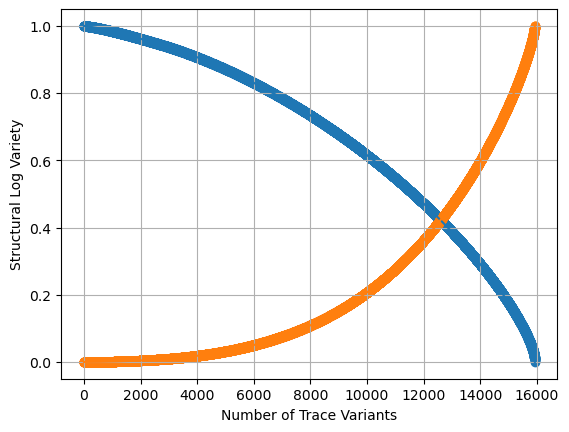

intersection: [12596]
area_trapeziodal: 3533.2826748142393
area_Simpson: 3533.2826157297236
Pearson's r: PearsonRResult(statistic=-0.9766545707564636, pvalue=0.0)
silhouette_value 0.0564100095777876


In [31]:
from scipy.cluster.hierarchy import fcluster
# Label für die y-Achse vergeben:
plt.ylabel('Structural Log Variety')
plt.xlabel('Number of Trace Variants')


x = list(range(0, len(cophenet_matrix)))
y = varietyDecrease
y = y / max(y) #normalization

y2 = alignCostIncrease
y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
plt.plot(x, y)
plt.plot(x, y2)

# plot scatter plot with x and y data 
plt.scatter(x, y)
plt.scatter(x, y2)

# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])

# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)

# Diagramm anzeigen:
plt.show()
    
idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
print("intersection:", idx)

# Area under Curve
#from scipy.integrate import simpson

area = trapz(y2, dx=1)
print("area_trapeziodal:", area)
# Compute the area using the composite Simpson's rule.
area = simpson(y2, dx=1)
print("area_Simpson:", area)


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    #print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    #print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

    #Evaluate Clustering
    #from scipy.cluster.hierarchy import fcluster
labels = fcluster(linkage_matrix, t=len(logVar)/2, criterion='maxclust')
silhoutte = metrics.silhouette_score(abs(lev_dis), labels, metric="precomputed")
print("silhouette_value", silhoutte)

## Baseline

In [39]:
#Derive ordering of traces based on random selection
import math

def marginal_variety_baseline(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    totalVariety = []
    numbVar = len(pairwise_distances)
    remaining = list(range(0,numbVar))
    
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(numbVar-1):
        if i % 250 == 0:
            print(i)
        
        #Select random variant to be removed
        indices = np.random.choice(remaining)
        remaining.remove(indices)
        min_val = np.nanmin(modified_distances[indices])
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = indices, indices
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)        
        margVariety.append(min_val)
        
        #Calculate variety based on distances of remaining traces 
        variety = 0
        for i in modified_distances:
            if math.isnan(np.nanmin(i)):
                continue
            variety += np.nanmin(i)
        totalVariety.append(variety)
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
        
    #return modified_distances
    return traceOrder, margVariety, totalVariety #modified_distances

In [40]:
def varAlignCosts2(Matrix_Align):

    #Derive ordering of traces based on their marginal distance
    #order, margVar = marginal_variety(cophenet_matrix)
    order, margVar, totalVar = marginal_variety_baseline(Matrix_Align)
    totalVar.append(0)
    
    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    print('margAlignCosts')
    
    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)
    
    
    
    #Calculate overall Variety based on sum of margVar
    logVariety = sum(margVar)
    print('Overall variety:', logVariety)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)


    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(Matrix_Align)))
    y = totalVar
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)
    
    #Monotonicity trend
    diffs = np.diff(totalVar)
    monoRate = np.sum(diffs >= 0) / (len(totalVar)-2)
    print("monotonViolation:", monoRate)
    print("equality:", np.sum(diffs == 0))
    print("increase:", np.sum(diffs > 0))


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

0


C:\Users\la1949\AppData\Local\Temp\ipykernel_18844\428584327.py:38: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
margAlignCosts
Overall variety: 85870.0


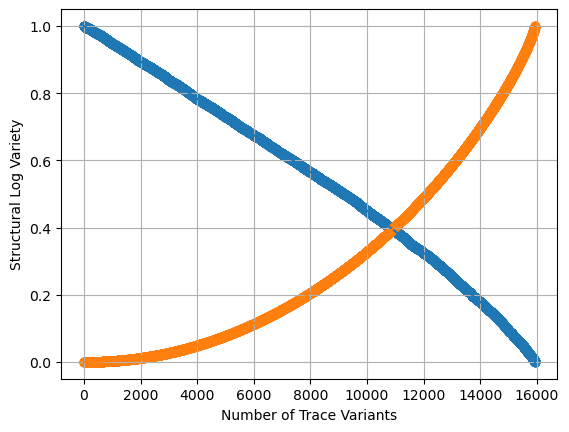

intersection: [10900]
area_trapeziodal: 4650.584912668301
area_Simpson: 4650.584844683615
monotonViolation: 0.18928930185836262
equality: 1544
increase: 1471
Pearson's r: PearsonRResult(statistic=-0.9712307426775155, pvalue=0.0)
Spearman's rho: SignificanceResult(statistic=-0.9999999785007938, pvalue=0.0)
Kendall's tau: SignificanceResult(statistic=-0.9999447953375304, pvalue=0.0)


In [41]:
varAlignCosts2(lev_dis)